При проектировании нейросетей часто используют различные модели для улучшения качества метрик. Чтобы применить модель, необходимо предварительно затратить существенные ресурсы на обработку всего массива необработанных данных. Инструмент Pipeline позволяет объединить несколько операций обработки данных в единую модель библиотеки Python «Scikit-learn».

Для изучения представленного инструмента, рассмотрим следующий набор программ. Данный блок загружает необходимые библиотеки для создания и работы с нейросетями и базами изображений, а также для рисования информативных графиков и продвинутых методов работы с данными.

In [ ]:
import os
import sys

import numpy

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_datasets as tf_ds
import matplotlib.pyplot as plt

Как и на прошлом занятии, мы будем использовать базу изображений MNIST. Также программно создадим все промежуточные каталоги для набора данных, если они (каталоги) не существуют.

Произведем загрузку данных. Представленные параметры обозначают соответственно: имя набора данных, какие части набора данных загружать, правило для больших наборов данных, правило для возвращения пары изображение-метка, описание набора данных.

In [ ]:
dataset_path = os.path.join(os.path.dirname(sys.argv[0]), 'mnist')
os.makedirs(dataset_path, exist_ok=True)

(ds_train, ds_test), ds_info = tf_ds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Далее необходимо выполнить несколько действий, которые можно вынести в отдельные функции. Сначала нам нужно нормализовать данные. Это необходимо, потому что мы работаем с данными, для которых достаточно ответа на вопрос “Присутствует ли изображение в клетке или нет”. В нашем случае, база MNIST содержит черно-белые рисунки с различными оттенками серого цвета, которые мы и нормализуем.

Затем нам необходимо увеличить эффективность работы нашей нейросети. Для этого воспользуемся инструментами pipeline, или конвейерами. Они объединяют несколько методов оценки данных в один общий, который более эффективен, чем составляющие его оценщики.

Поскольку мы используем тренировочную и тестовую выборки, напишем конвейеры для оценки каждой из выборок. Если Вам интересно описание выполняемых операций, можете вызвать подсказку.

In [ ]:
def normalize_data(image, label):
    return tf.cast(image, tf.float32) / 255.0, label
    
def train_pipeline(dataset):
    dataset = dataset.map(normalize_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(ds_info.splits['train'].num_examples)
    dataset = dataset.batch(128)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def test_pipeline(dataset):
    dataset = dataset.map(normalize_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(128)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

После проделанных действий приступим к описанию структуры нейросети и подготовке её к обучению. С данными операциями Вы уже сталкивались на прошлой лекции. Разница заключается лишь в наличии большего количества нейронов во внутренних слоях нейросети.

In [ ]:
def configure_network(value_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=value_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

Затем произведем конфигурирование и обучение нейросети. Для выполнения первого действия вызовем конвейеры, которые мы определили на прошлых этапах. После того как выполнена конфигурирование набора данных, обучим нейросеть и выведем её точность в каждой эпохе.

После этого выведем на экран значений потерь в обучающей и контрольной выборке для оценки точности работы нейронной сети.

В конце, сохраним полученные данные в файл и вернем их в программу для дальнейшего анализа.

In [ ]:
def learning(model):
    ds_train = train_pipeline(train)
    ds_test = test_pipeline(test)
    history = model.fit(ds_train, epochs=10, verbose=1)
    for i, v in enumerate(history.history['accuracy'], 1):
        print(f'Epoch {i}: accuracy {v:.1%}')

    train_loss, train_acc = model.evaluate(ds_train, verbose=2)
    print(f'Accuracy on training images: {train_acc}')
    test_loss, test_acc = model.evaluate(ds_test, verbose=2)
    print(f'Accuracy on testing images: {test_acc}')

    model.save('digits.h5')

    return history

Epoch 1/10
469/469 [==============================] - 6s 2ms/step - loss: 0.2923 - accuracy: 0.9104
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1592 - accuracy: 0.9522
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1334 - accuracy: 0.9595
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1206 - accuracy: 0.9633
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1091 - accuracy: 0.9665
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1022 - accuracy: 0.9689
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.9697
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0926 - accuracy: 0.9719
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9710
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0893 - accuracy: 0.9725

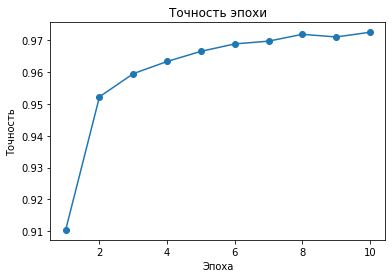

In [ ]:
(train, test), ds_info = tf_ds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
Epoch = range(1, 11)
data = learning(configure_network(1e-2)).history["accuracy"]
plt.plot(Epoch, data)
plt.scatter(Epoch, data)
plt.title("Точность эпохи")
plt.ylabel("Точность")
plt.xlabel("Эпоха")
plt.show()